# 문제 정의

- 보스턴 주택 가격 예측
- 특성공학과 회귀모델(랜덤 포레스트와 부스팅)

## 라이브러리 로딩

In [10]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns

# 음수표현 라이브러리
plt.rcParams['axes.unicode_minus'] = False

# 경고무시
import warnings
warnings.filterwarnings("ignore")

# 스타일
sns.set_style('darkgrid') 

# 매직명령어 : 시각화 결과가 노트북에 포함되도록
%matplotlib inline

In [27]:
pd.options.display.max_columns = 200
pd.set_option('display.max_rows', 200)

## 데이터셋 로딩

In [2]:
# 소수점 표현 제한
pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))

In [4]:
path = "C:/k_digital/Machine Learning with Python/source/house_price/"
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

In [5]:
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [6]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_ID = train_df['Id']
test_ID = test_df['Id']

train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

## 데이터 전처리

### 이상치 분석

- GrLivArea: Above grade (ground) living area square feet
- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.

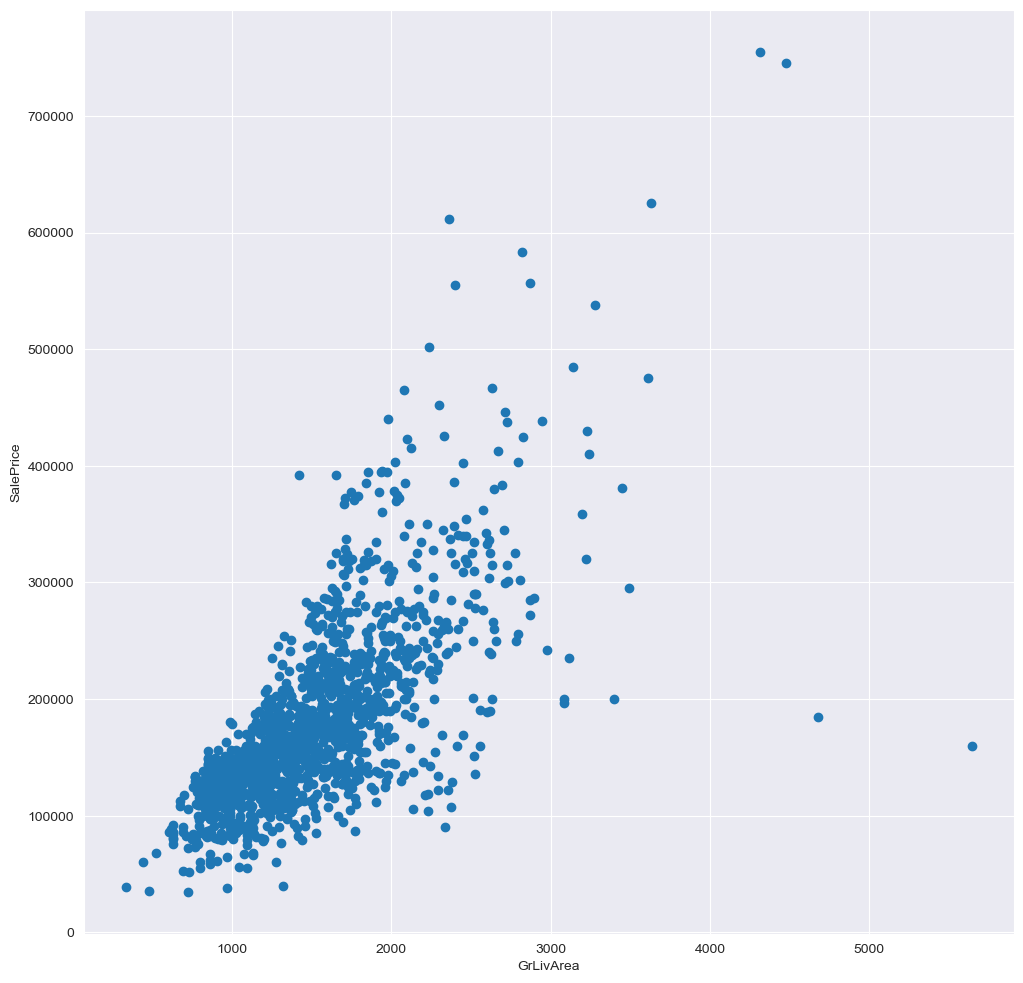

In [11]:
plt.figure(figsize=(12, 12))
plt.scatter(x = train_df['GrLivArea'], y= train_df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [12]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index) 

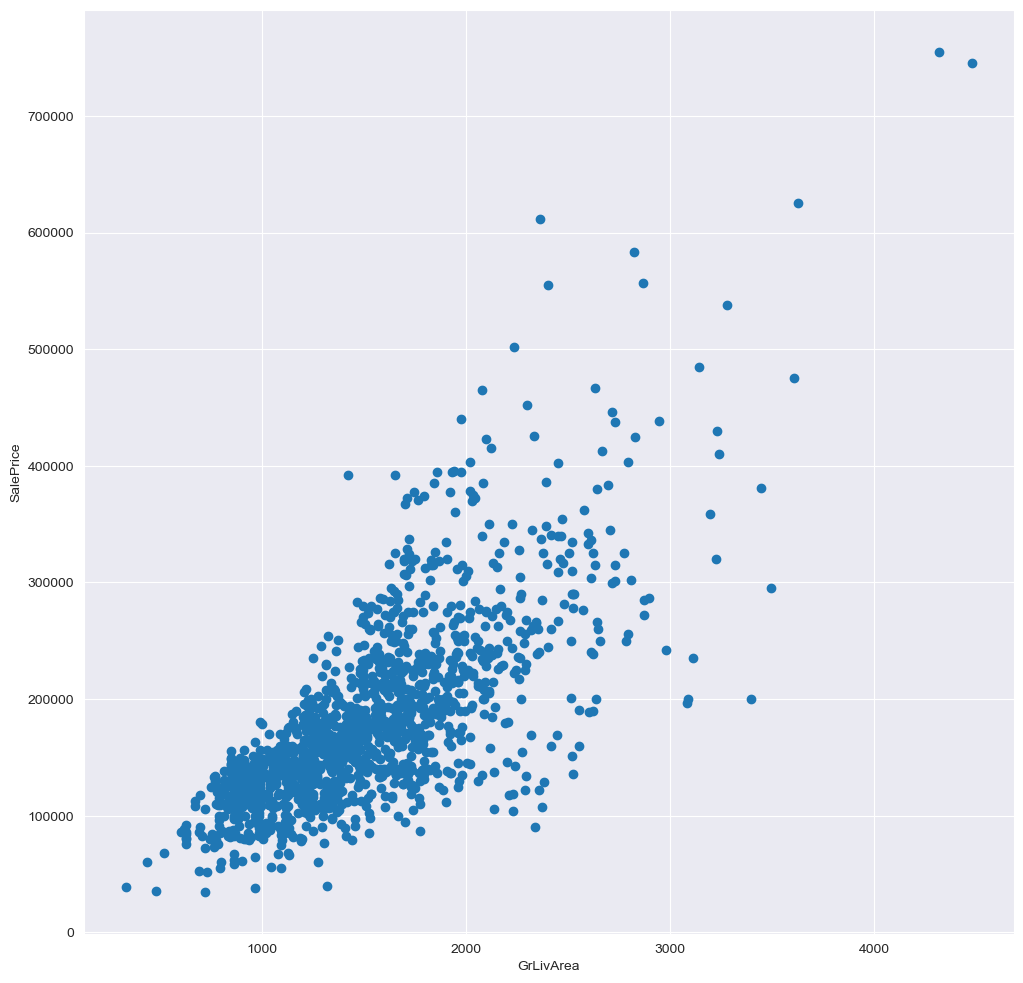

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(x = train_df['GrLivArea'], y= train_df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

### Target : SalePrice분석

- Q-Q Plot : 두 데이터 집단 간의 분포 체크
- Q-Q wiki
- Q-Q plot 한글 블로그 자료 : sw4r님

180932.91906721535 79467.78892987774


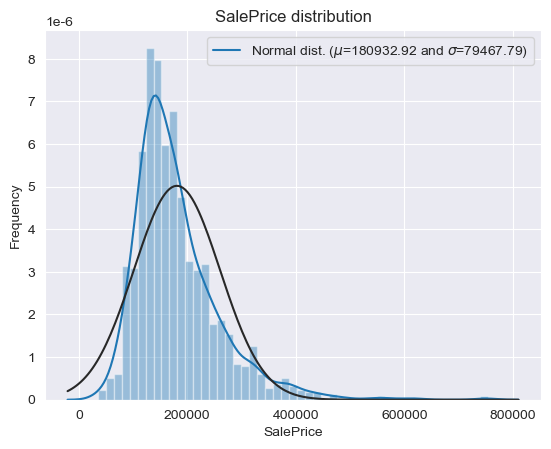

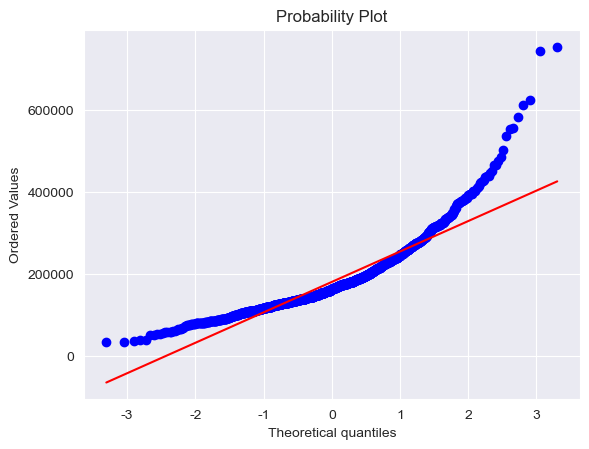

In [14]:
from scipy import stats
from scipy.stats import norm, skew

sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 분포를 그래프에 그려봅시다
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

- 분포가 오른쪽으로 치우친 경향을 보인다.
- 선형 모델을 사용할 경우 분포가 균형잡힌 상태에 더 용이하다

12.024015155682552 0.3995757283645756


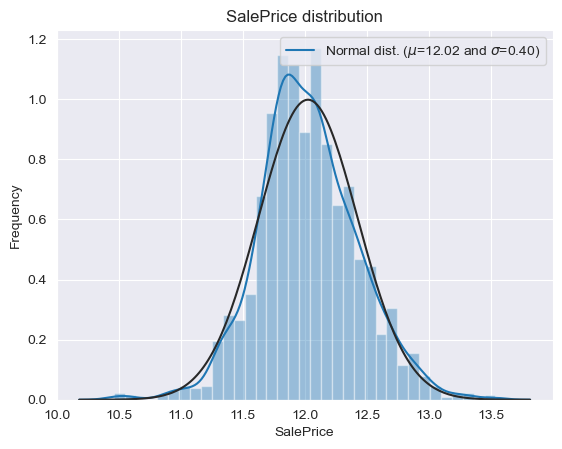

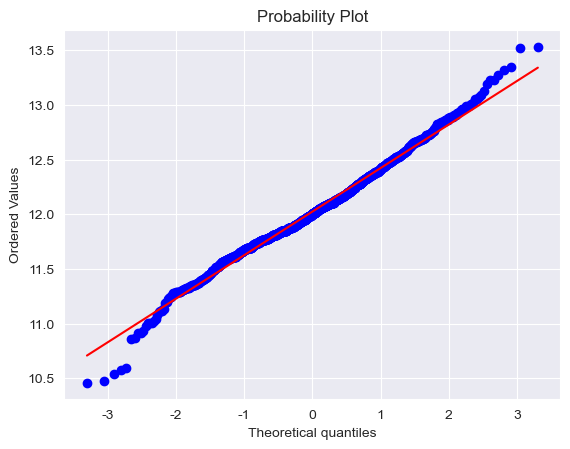

In [15]:
# 데이터의 정규화를 위한 numpy의 log1p 함수를 사용
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

- 정규분포에 매우 근접하게 값들이 바뀐것을 확인할 수 있다.

### Feature Engineering

In [16]:
test_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [17]:
y_train = train_df.SalePrice.values

train_df.drop(['SalePrice'], axis=1, inplace=True)

- 결측치 처리

In [18]:
train_df.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 79, dtype: int64

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   object 
 2   LotFrontage    1199 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1458 non-null   object 
 7   LandContour    1458 non-null   object 
 8   Utilities      1458 non-null   object 
 9   LotConfig      1458 non-null   object 
 10  LandSlope      1458 non-null   object 
 11  Neighborhood   1458 non-null   object 
 12  Condition1     1458 non-null   object 
 13  Condition2     1458 non-null   object 
 14  BldgType       1458 non-null   object 
 15  HouseStyle     1458 non-null   object 
 16  OverallQual    1458 non-null   int64  
 17  OverallCond    1458 non-null   int64  
 18  YearBuil

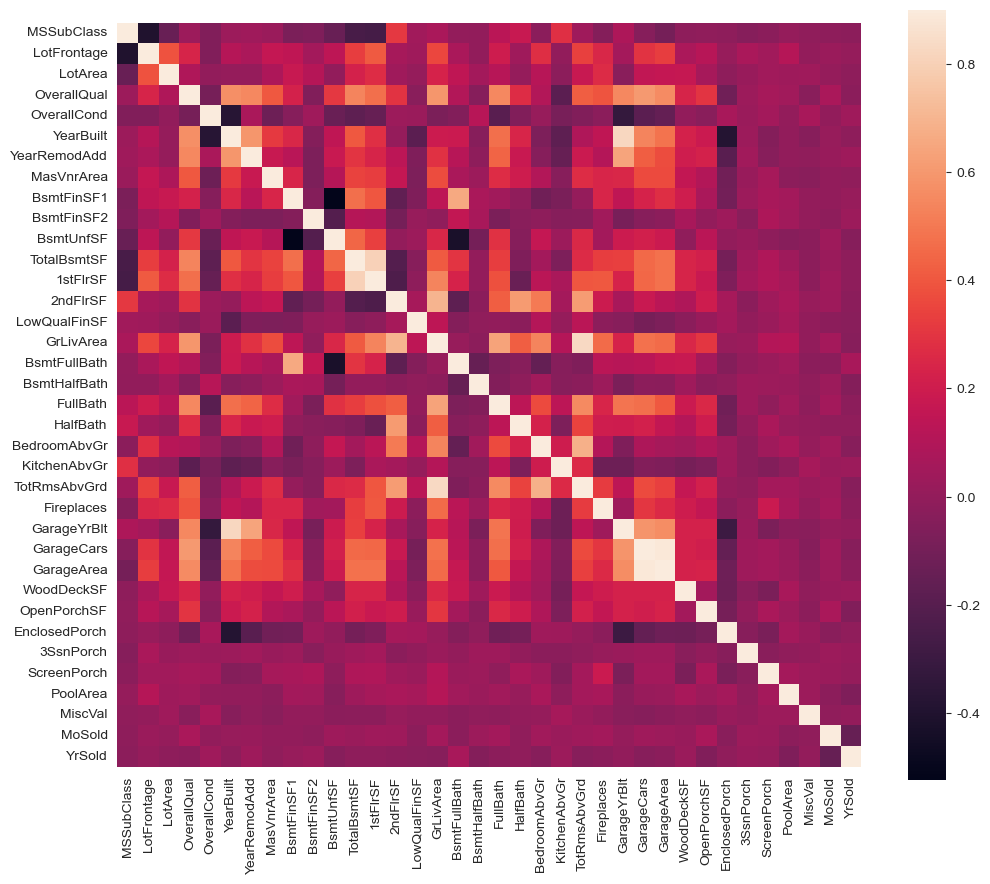

In [20]:
corr = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, vmax=0.9, square=True)
plt.show()

- 분석을 위해 train, test 데이터셋 합치기

In [22]:
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
#all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2917, 79)

### 결측치 처리

- 수치형 데이터의 경우 0, 범주형 데이터의 경우 'None'로 대체

In [28]:
rate = (all_data.isnull().sum() / len(all_data)) * 100
rate = rate.drop(rate[rate == 0].index).sort_values(ascending=False)

missing_data = pd.DataFrame({'Missing Rate':rate})
missing_data

,Missing Rate
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


- PoolQC : NA값은 'No Pool'을 의미	

In [29]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

- MiscFeature, Alley, Fence, FireplaceQu : 없음을 의미 

In [30]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
all_data['Alley'] = all_data['Alley'].fillna('None')
all_data['Fence'] = all_data['Fence'].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- LotFrontage : Linear feet of street connected to property
- 거리와 집의 거리를 나타냄
- 이웃들의 거리와 유사하다고 판단하여 이웃들의 중앙값으로 대체

In [39]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual, GarageCond 모두 Na => None

In [32]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

In [33]:
for col in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[col] = all_data[col].fillna(0)

In [34]:
col_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in col_list:
    all_data[col] = all_data[col].fillna('None')

In [35]:
for col in ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    all_data[col] = all_data[col].fillna(0)

In [36]:
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

- MSZoning: the general zoning classification
- RL이 최빈값으로 빈 부분은 RL로 채움

In [37]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [40]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2917 non-null   object 
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          2917 non-null   object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

In [41]:
rate = (all_data.isnull().sum() / len(all_data)) * 100
rate = rate.drop(rate[rate == 0].index).sort_values(ascending=False)

missing_data = pd.DataFrame({'Missing Rate':rate})
missing_data

,Missing Rate
Utilities,0.069
Functional,0.069
Exterior1st,0.034
Exterior2nd,0.034
Electrical,0.034
KitchenQual,0.034
SaleType,0.034


- Utilities: Type of utilities available 

In [42]:
all_data = all_data.drop(['Utilities'], axis=1)

- Functional

In [43]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

- Exterior1st, Exterior2nd, Electrical, KitchenQual, SaleType 모두 최빈값 대체

In [44]:
for col in ['Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'SaleType']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [45]:
rate = (all_data.isnull().sum() / len(all_data)) * 100
rate = rate.drop(rate[rate == 0].index).sort_values(ascending=False)

missing_data = pd.DataFrame({'Missing Rate':rate})
missing_data

,Missing Rate


### 형변환

In [46]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2917 non-null   object 
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          2917 non-null   object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   LotConfig      2917 non-null   object 
 9   LandSlope      2917 non-null   object 
 10  Neighborhood   2917 non-null   object 
 11  Condition1     2917 non-null   object 
 12  Condition2     2917 non-null   object 
 13  BldgType       2917 non-null   object 
 14  HouseStyle     2917 non-null   object 
 15  OverallQual    2917 non-null   int64  
 16  OverallCond    2917 non-null   int64  
 17  YearBuilt      2917 non-null   int64  
 18  YearRemo

In [47]:
# 수치형 값들 중 범주형의 특성을 가진것 변환

for col in ['MSSubClass', 'OverallQual']:
    all_data[col] = all_data[col].astype(str)